<a href="https://colab.research.google.com/github/Ismail-Armutcu/Algorithms-for-Interactive-Sytems/blob/main/MMI_HW2_NOISE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MMI513 Programming Assignment 2**
## Noise
- İsmail Hakkı Armutcu
- 2374395

In [96]:
import numpy as np
import sys
from random import seed, randint
import matplotlib.pyplot as plt
from math import isclose
from scipy.spatial.distance import chebyshev as cheby
import seaborn as sns
#import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

In [22]:
def lcg(modulus, a, c, seed):
    seed = (a * seed + c) % modulus
    return seed

def bitsrequired(n):
    if n==0:
        numbits = 1
    else:
        n = abs(n)
        numbits = int(1 + np.floor( np.log2( n + 1 ) ))
    return numbits

def noiserandom(N, m=2**21-1, S0=117456):
    sval = morton(N) + S0
    r = lcg(m, 413585, 1171173, sval)
    s = r / (m+1)
    return 2 * s - 1

def morton(Z, b=None):
    m = 1 # Left shifting bit mask
    n = len(Z)
    S = np.arange(n)
    if b==None:
        assert (Z>=0).all() # Check if all elements are non-negative
        numbitsmin = bitsrequired(np.min(Z))
        numbitsmax = bitsrequired(np.max(Z))
        b = max(numbitsmin, numbitsmax)
    r = 0
    for c in range(b): # Repeat b times
        for ind in range(n):
            r = r | ((Z[ind] & m) << S[ind])
            S[ind] += (n - 1)
        m = m << 1
    return r

In [23]:
def unitlerp(a0, a1, t):
    # Linear interpolation with mixin weight, t
    assert(t >= 0 and t <= 1)
    return a0 * ( 1 - t ) + a1 * t
def valueinterpolation1(a0, a1, t, infun):
    return unitlerp(a0, a1, infun(t))

def smootherstep(t):
    assert (t<=1) and (t>=0)
    return 6 * t**5 - 15 * t**4 + 10*t**3

In [24]:
def positioninunitcircle():
    while True:
        x = 2 * np.random.rand() - 1
        y = 2 * np.random.rand() - 1
        s = x**2 + y**2
        if s>0 and s<1:
            break
    return x, y, s

def randomnormal_01pair():
    x, y, s = positioninunitcircle()
    if isclose(s,0):
        return np.array([0.,0.])
    c = np.sqrt(-2*np.log(s)/s)
    x0 = x * c
    x1 = y * c
    return np.array([x0, x1])

def randomonunitsphere(numdim, seed):
    np.random.seed(seed)
    d = numdim
    R = np.zeros(numdim)
    xi = 0
    while 2<=d:
        d -= 2
        x, y, s = positioninunitcircle()
        if isclose(s,0):
            R[d] = 0
            R[d + 1] = 0
        else:
            q = -2 * np.log(s)
            xi += q
            c = np.sqrt(q/s)
            R[d] = x * c
            R[d + 1] = y * c
    if d==1:
        x, y, s = positioninunitcircle()
        if isclose(s,0):
            R[0] = 0
        else:
            R[0] = x * np.sqrt(-2 * np.log(s) / s)
            xi += R[0]**2
    if isclose(xi, 0):
        return randomonunitsphere(numdim)
    R /= np.sqrt(xi)
    return R

def noiserandomvector(N, n):
    seed = morton(N)
    R = randomonunitsphere(n, seed)
    return R

def noiseperlin(x, y):
    assert x>=0 and y>=0
    xw = np.floor(x)
    yw = np.floor(y)
    xf = x - xw
    yf = y - yw
    a00 = noiserandomvector(np.array([xw, yw], np.int32), 2)
    a10 = noiserandomvector(np.array([xw + 1, yw], np.int32), 2)
    a01 = noiserandomvector(np.array([xw, yw + 1], np.int32), 2)
    a11 = noiserandomvector(np.array([xw + 1, yw + 1], np.int32), 2)
    pt = np.array([x, y])
    v00 = pt - np.array([xw, yw])
    v10 = pt - np.array([xw + 1, yw])
    v01 = pt - np.array([xw, yw + 1])
    v11 = pt - np.array([xw + 1, yw + 1])
    d00 = np.sum(a00 * v00)
    d01 = np.sum(a01 * v01)
    d10 = np.sum(a10 * v10)
    d11 = np.sum(a11 * v11)
    ds0 = valueinterpolation1(d00, d10, xf, smootherstep)
    ds1 = valueinterpolation1(d01, d11, xf, smootherstep)
    val = valueinterpolation1(ds0, ds1, yf, smootherstep)
    return val

def vanillaperlin(xmin, xmax, ymin, ymax, Kx, Ky):
    img = np.zeros((Kx, Ky))
    xgrid = np.linspace(xmin, xmax, Kx)
    ygrid = np.linspace(ymin, ymax, Ky)
    for ind in range(Kx):
        for jnd in range(Ky):
            img[ind, jnd] = noiseperlin(xgrid[ind], ygrid[jnd])
    return img

def composedperlin(xmin, xmax, ymin, ymax, Kx, Ky, l, a0, f0):
    r = np.zeros((Kx, Ky))
    rmax = np.zeros((Kx, Ky))
    for ind in range(l):
        a = a0**ind
        f = f0**ind
        r = r + a * vanillaperlin(xmin * f, xmax * f, ymin * f, ymax * f, Kx, Ky)
        rmax = rmax + a
    return r / rmax

def turbulencedperlin(xmin, xmax, ymin, ymax, Kx, Ky, l, a0, f0):
    r = np.zeros((Kx, Ky))
    rmax = np.zeros((Kx, Ky))
    for ind in range(l):
        a = a0**ind
        f = f0**ind
        r = r + np.abs(a * vanillaperlin(xmin * f, xmax * f, ymin * f, ymax * f, Kx, Ky))
        rmax = rmax + a
    return r / rmax

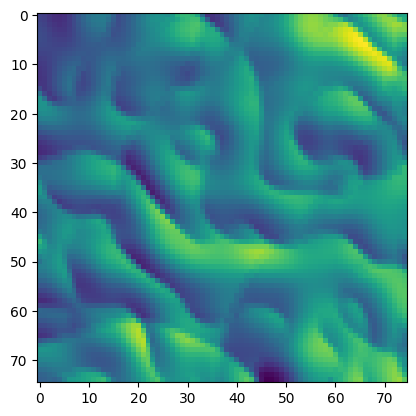

In [139]:
def calculate_curl(img):
  dx = np.gradient(img, axis=1)
  dy = np.gradient(img, axis=0)
  curl_field = dy - dx
  return curl_field

# Create a placeholder 2D scalar field (replace with your own data)
images = []
num = 25
def create_perlin(num):
  return calculate_curl(turbulencedperlin(num, num+1, num, num+1, 75, 75, 3, 0.5, np.sqrt(5)))

for i in range(num):
  images.append(create_perlin(i))


# Create a figure and axis
frames = images

# Create a figure and axis
fig, ax = plt.subplots()

# Create an empty plot
im = ax.imshow(frames[0], cmap='viridis', animated=True)

# Function to update the plot for each frame
def update(frame):
    im.set_array(frame)
    return [im]

# Create the animation
animation = FuncAnimation(fig, update, frames=frames, interval=200, blit=True)

plt.show()
from IPython.display import HTML
HTML(animation.to_html5_video())
